In [1]:
#import packages

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss 
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from matplotlib.pyplot import figure

In [2]:
# read data

T1 = pd.read_csv('t1_user_active_min.csv')
T2 = pd.read_csv('t2_user_variant.csv')
T3 = pd.read_csv('t3_user_active_min_pre.csv')
T4 = pd.read_csv('t4_user_attributes.csv')

In [3]:
# look at data

T1.head(10)

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0
5,0,2019-04-06,1.0
6,0,2019-04-17,1.0
7,0,2019-05-07,3.0
8,0,2019-05-14,1.0
9,0,2019-05-19,1.0


In [4]:
T2.head(10)

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09
5,5,0,2019-02-06,2018-06-25
6,6,0,2019-02-06,2017-01-22
7,7,0,2019-02-06,2016-08-12
8,8,0,2019-02-06,2019-01-18
9,9,0,2019-02-06,2018-05-02


In [5]:
T3.head(10)

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0
5,0,2018-12-04,1.0
6,0,2018-12-07,8.0
7,0,2018-12-09,5.0
8,0,2018-12-14,8.0
9,0,2018-12-15,2.0


In [6]:
T4.head(10)

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader
5,5,female,non_reader
6,6,female,non_reader
7,7,male,non_reader
8,8,male,new_user
9,9,female,non_reader


Hypothesis:
Changes implemented for group B has increased user engagement

I will also break down whether

1) Active usership time increased or decreased

2) Frequency of visits increased or decreased

3) Do the above two points for old/new users, male/female users, and if they are readers/non-readers.

In [7]:
# see number of control group users and test group users.

T2['variant_number'].value_counts()

# 80% in control(40k), 20% in treatment/test group (10k)

0    40000
1    10000
Name: variant_number, dtype: int64

In [8]:
# load users into control and treatment/test group arrays.

user_control = []
user_treatment = []
for index,row in T2.iterrows():
    if row['variant_number'] == 0:
        user_control.append(row['uid'])
    else:
        user_treatment.append(row['uid'])

In [9]:
# merge attributes table and variant table.

var_gen_ageinquora = pd.merge(T2,T4,how = "inner", on = "uid")

In [10]:
var_gen_ageinquora.head()

,uid,variant_number,dt,signup_date,gender,user_type
0,0,0,2019-02-06,2018-09-24,male,non_reader
1,1,0,2019-02-06,2016-11-07,male,reader
2,2,0,2019-02-06,2018-09-17,male,non_reader
3,3,0,2019-02-06,2018-03-04,male,non_reader
4,4,0,2019-02-06,2017-03-09,male,non_reader


In [11]:
# split var_gen_ageinquora into control and treatment groups.

var_gen_ageinquora_control = var_gen_ageinquora[var_gen_ageinquora['variant_number'] == 0]
var_gen_ageinquora_treatment = var_gen_ageinquora[var_gen_ageinquora['variant_number'] == 1]
cat_cols = ['gender','user_type']
cont_cols = ['days_since_joined_till_AB_tested']

In [12]:
# sort control and treatment groups into arrays based on if they are in treatment or control and date they joined before ab test.

uid_control         = list(var_gen_ageinquora_control["uid"])
uid_treatment       = list(var_gen_ageinquora_treatment["uid"])
before_AB_control   = T3[T3['uid'].isin(uid_control)] 
before_AB_treatment = T3[T3['uid'].isin(uid_treatment)]
after_AB_control    = T1[T1['uid'].isin(uid_control)]
after_AB_treatment  = T1[T1['uid'].isin(uid_treatment)]

In [13]:
# looks at created arrays

after_AB_treatment.head()

,uid,dt,active_mins
886957,40000,2019-02-13,3.0
886958,40000,2019-03-02,18.0
886959,40000,2019-03-12,4.0
886960,40001,2019-02-14,16.0
886961,40001,2019-02-17,5.0


In [14]:
after_AB_control.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [15]:
before_AB_treatment.head()

,uid,dt,active_mins
989489,40001,2018-08-12,1.0
989490,40001,2018-08-21,1.0
989491,40001,2018-09-21,5.0
989492,40001,2018-09-23,3.0
989493,40001,2018-10-03,1.0


In [16]:
before_AB_control.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [17]:
# merge the control/test and date tables with the attributes table

before_AB_control_base_table   = pd.merge(before_AB_control,var_gen_ageinquora, how = "inner", on = "uid")
before_AB_treatment_base_table = pd.merge(before_AB_treatment,var_gen_ageinquora, how = "inner", on = "uid")
after_AB_control_base_table    = pd.merge(after_AB_control,var_gen_ageinquora, how = "inner", on = "uid")
after_AB_treatment_base_table  = pd.merge(after_AB_treatment,var_gen_ageinquora, how = "inner", on = "uid")

In [18]:
# renaming some columns

before_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_control_base_table.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,0,2018-09-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
1,0,2018-11-08,4.0,0,2019-02-06,2018-09-24,male,non_reader
2,0,2018-11-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
3,0,2018-11-28,6.0,0,2019-02-06,2018-09-24,male,non_reader
4,0,2018-12-02,6.0,0,2019-02-06,2018-09-24,male,non_reader


In [19]:
before_AB_treatment_base_table_noout = before_AB_treatment_base_table[before_AB_treatment_base_table.active_mins < np.percentile(before_AB_treatment_base_table.active_mins,92)]
after_AB_treatment_base_table_noout = after_AB_treatment_base_table[after_AB_treatment_base_table.active_mins < np.percentile(after_AB_treatment_base_table.active_mins,92)]

In [20]:
before_AB_treatment_base_table_noout.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,40001,2018-08-12,1.0,1,2019-02-06,2017-04-29,male,non_reader
1,40001,2018-08-21,1.0,1,2019-02-06,2017-04-29,male,non_reader
2,40001,2018-09-21,5.0,1,2019-02-06,2017-04-29,male,non_reader
3,40001,2018-09-23,3.0,1,2019-02-06,2017-04-29,male,non_reader
4,40001,2018-10-03,1.0,1,2019-02-06,2017-04-29,male,non_reader


C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

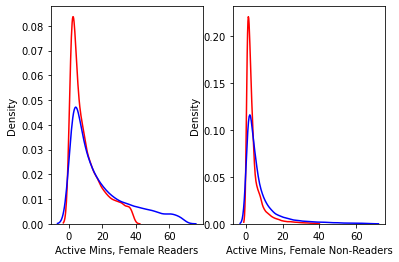

In [21]:
# plot of male readers for before (orange) and after (blue) data
f, axes = plt.subplots(1, 2)
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)

sns.distplot(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == 'female')&(before_AB_treatment_base_table_noout["user_type"] == "reader")]["active_mins"],
             hist=False,color='red', axlabel = "Active Mins, Female Readers",ax=axes[0])
sns.distplot(after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == 'female')&(after_AB_treatment_base_table_noout["user_type"] == "reader")]["active_mins"],
             hist=False,color='blue', axlabel = "Active Mins, Female Readers",ax=axes[0])
sns.distplot(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == 'female')&(before_AB_treatment_base_table_noout["user_type"] == "non_reader")]["active_mins"],
             hist=False,color='red', axlabel = "Active Mins, Female Non-Readers",ax=axes[1])
sns.distplot(after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == 'female')&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")]["active_mins"],
             hist=False,color='blue', axlabel = "Active Mins, Female Non-Readers",ax=axes[1])


plt.show()

C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

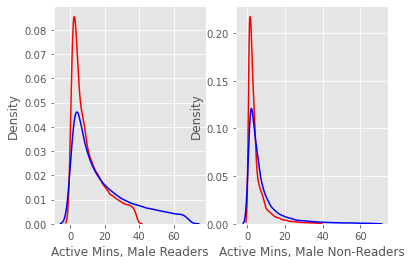

In [22]:
# plot of male readers for before (orange) and after (blue) data
f, axes = plt.subplots(1, 2)
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)

sns.distplot(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == 'male')&(before_AB_treatment_base_table_noout["user_type"] == "reader")]["active_mins"],
             hist=False, color='red', axlabel = "Active Mins, Male Readers",ax=axes[0])
sns.distplot( after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == 'male')&(after_AB_treatment_base_table_noout["user_type"] == "reader")]["active_mins"],
             hist=False, color='blue', axlabel = "Active Mins, Male Readers",ax=axes[0])
sns.distplot(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == 'male')&(before_AB_treatment_base_table_noout["user_type"] == "non_reader")]["active_mins"],
             hist=False,color='red', axlabel = "Active Mins, Male Non-Readers",ax=axes[1])
sns.distplot( after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == 'male')&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")]["active_mins"],
             hist=False,color='blue', axlabel = "Active Mins, Male Non-Readers",ax=axes[1])


plt.show()

In [23]:
user_count_before_AB = pd.DataFrame(before_AB_treatment_base_table_noout['uid'].value_counts())
user_count_before_AB.reset_index(inplace = True)
user_count_before_AB.rename(columns = {'uid':'before_count', 'index':'uid'}, inplace = True)
user_count_after_AB = pd.DataFrame(after_AB_treatment_base_table_noout['uid'].value_counts())
user_count_after_AB.reset_index(inplace = True)
user_count_after_AB.rename(columns = {'uid':'after_count', 'index':'uid'}, inplace = True)

C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


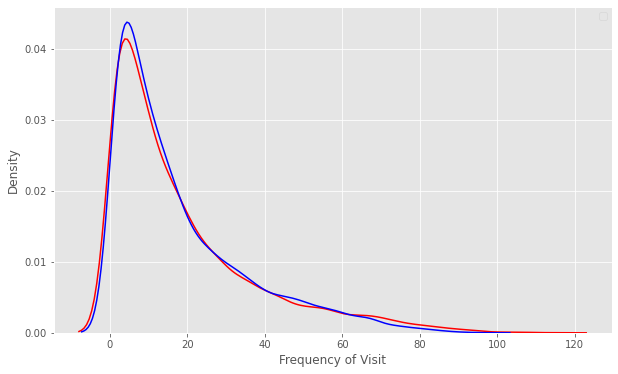

In [24]:
fig = plt.figure(figsize=(10,6))
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)

sns.distplot(user_count_before_AB['before_count'], hist=False, color='red', axlabel = "Frequency of Visit")
sns.distplot(user_count_after_AB['after_count'], hist=False, color='blue', axlabel = "Frequency of Visit")

plt.legend()
plt.show()

In [25]:
after_AB_control_base_table_noout = after_AB_control_base_table[after_AB_control_base_table.active_mins < np.percentile(after_AB_control_base_table.active_mins,92)]
after_AB_treatment_base_table_noout = after_AB_treatment_base_table[after_AB_treatment_base_table.active_mins < np.percentile(after_AB_treatment_base_table.active_mins,92)]

In [26]:
after_AB_treatment_base_table_noout.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,40000,2019-02-13,3.0,1,2019-02-06,2019-02-04,male,new_user
1,40000,2019-03-02,18.0,1,2019-02-06,2019-02-04,male,new_user
2,40000,2019-03-12,4.0,1,2019-02-06,2019-02-04,male,new_user
3,40001,2019-02-14,16.0,1,2019-02-06,2017-04-29,male,non_reader
4,40001,2019-02-17,5.0,1,2019-02-06,2017-04-29,male,non_reader


In [27]:
after_AB_control_base_table_noout.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,0,2019-02-22,5.0,0,2019-02-06,2018-09-24,male,non_reader
1,0,2019-03-11,5.0,0,2019-02-06,2018-09-24,male,non_reader
2,0,2019-03-18,3.0,0,2019-02-06,2018-09-24,male,non_reader
3,0,2019-03-22,4.0,0,2019-02-06,2018-09-24,male,non_reader
4,0,2019-04-03,9.0,0,2019-02-06,2018-09-24,male,non_reader


C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

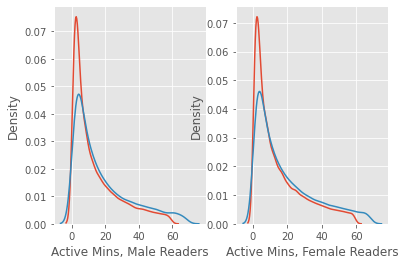

In [28]:
# plot of male/female readers for control and treatment data after the ab date


f, axes = plt.subplots(1, 2) 
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)

sns.distplot(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == 'female')&(after_AB_control_base_table_noout["user_type"] == "reader")]['active_mins'],
             hist=False, axlabel = "Active Mins, Male Readers",ax=axes[0])
sns.distplot(after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == 'female')&(after_AB_treatment_base_table_noout["user_type"] == "reader")]['active_mins'],
             hist=False, axlabel = "Active Mins, Male Readers",ax=axes[0])
sns.distplot(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == 'male')&(after_AB_control_base_table_noout["user_type"] == "reader")]['active_mins'],
             hist=False, axlabel = "Active Mins, Female Readers",ax=axes[1])
sns.distplot(after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == 'male')&(after_AB_treatment_base_table_noout["user_type"] == "reader")]['active_mins'],
             hist=False, axlabel = "Active Mins, Female Readers",ax=axes[1])


plt.show()

C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\avand\anaconda3\envs\Data_sci\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

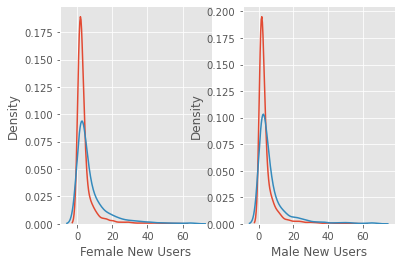

In [29]:
# plot of male/female readers for control and treatment data after the ab date


f, axes = plt.subplots(1, 2) 
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)

sns.distplot(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "female")&(after_AB_control_base_table_noout["user_type"] == "new_user")]['active_mins'],
             hist=False, axlabel = "Female New Users",ax=axes[0])
sns.distplot(after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")]['active_mins'],
             hist=False, axlabel = "Female New Users",ax=axes[0])
sns.distplot(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "male")&(after_AB_control_base_table_noout["user_type"] == "new_user")]['active_mins'],
             hist=False, axlabel = "Male New Users",ax=axes[1])
sns.distplot(after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")]['active_mins'],
             hist=False, axlabel = "Male New Users",ax=axes[1])


plt.show()
    

In [30]:
#columns i don't need

col_to_drop = ['date','AB_Date','signup_date']

In [31]:
# function to turn gender into dummy variable

def mapMaleFemale(df):
    return df['gender'].map({'female':0, 'male':1})

In [32]:
# add gender to arrays of attributes and active minutes for control and treatment

before_AB_treatment_base_table['gender'] = mapMaleFemale(before_AB_treatment_base_table)
before_AB_control_base_table['gender'] = mapMaleFemale(before_AB_control_base_table)
after_AB_control_base_table['gender'] = mapMaleFemale(after_AB_control_base_table)
after_AB_treatment_base_table['gender'] = mapMaleFemale(after_AB_treatment_base_table)
after_AB_control_base_table.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,0,2019-02-22,5.0,0,2019-02-06,2018-09-24,1.0,non_reader
1,0,2019-03-11,5.0,0,2019-02-06,2018-09-24,1.0,non_reader
2,0,2019-03-18,3.0,0,2019-02-06,2018-09-24,1.0,non_reader
3,0,2019-03-22,4.0,0,2019-02-06,2018-09-24,1.0,non_reader
4,0,2019-04-03,9.0,0,2019-02-06,2018-09-24,1.0,non_reader


In [33]:
total_control= pd.merge(after_AB_control_base_table,before_AB_control_base_table,how = "inner",on = "uid")
total_treatment=pd.merge(before_AB_treatment_base_table,after_AB_treatment_base_table, how='inner',on='uid')

In [34]:
# Function to order tables how i would like them for my analysis

def finalizeDataTables(df,col_to_drop, generateFile):
    # dum_1 = pd.get_dummies(before_AB_control_base_table['gender'])
    dum_2 = pd.get_dummies(df['user_type'])
    df = pd.concat([df,dum_2], axis = 1)
    df.drop(columns = col_to_drop, inplace = True)
    a = pd.DataFrame(df['uid'].value_counts())
    a.reset_index(inplace = True)
    a.rename(columns = {'uid':'appearences','index':'uid'}, inplace = True)
    df = pd.merge(df,a,how = "inner",on = "uid")
    col_to_group_by = list(df.columns)
    col_to_group_by.remove('active_mins')
    df = pd.DataFrame(df.groupby(col_to_group_by)['active_mins'].sum())
    df.reset_index(inplace = True)
    df.drop(columns = ['user_type'], inplace = True)
    df['avg_time_per_user'] = df['active_mins']/df['appearences']
    if generateFile:
        df.to_csv(df+".csv", index = False)
    return df

In [35]:
# passing tables through above function
before_AB_control_base_table = finalizeDataTables(before_AB_control_base_table,col_to_drop, False)
before_AB_treatment_base_table = finalizeDataTables(before_AB_treatment_base_table,col_to_drop, False)
after_AB_control_base_table = finalizeDataTables(after_AB_control_base_table,col_to_drop, False)
after_AB_treatment_base_table = finalizeDataTables(after_AB_treatment_base_table,col_to_drop, False)

In [36]:
before_AB_control_base_table.describe()

,uid,variant_number,gender,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,33655.000000,33655.0,33655.000000,33655.000000,33655.000000,33655.000000,33655.000000,33655.000000,3.365500e+04,33655.000000
mean,19988.265102,0.0,0.657644,0.024335,0.083019,0.715941,0.176705,25.609568,9.373640e+02,13.675639
std,11544.409961,0.0,0.474505,0.154090,0.275915,0.450972,0.381424,27.398864,1.748716e+04,183.041285
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,1.000000
25%,9999.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.900000e+01,2.620690
50%,19967.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,15.000000,5.700000e+01,4.000000
75%,30011.500000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,35.000000,2.050000e+02,7.323529
max,39999.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,133.000000,1.345714e+06,15448.000000


In [37]:
# filter outliers
before_AB_control_base_table=before_AB_control_base_table[(np.abs(ss.zscore(before_AB_control_base_table['avg_time_per_user'])) < 4)]
before_AB_treatment_base_table=before_AB_treatment_base_table[(np.abs(ss.zscore(before_AB_treatment_base_table['avg_time_per_user'])) < 4)]
after_AB_control_base_table=after_AB_control_base_table[(np.abs(ss.zscore(after_AB_control_base_table['avg_time_per_user'])) < 4)]
after_AB_treatment_base_table=after_AB_treatment_base_table[(np.abs(ss.zscore(after_AB_treatment_base_table['avg_time_per_user'])) < 4)]

before_AB_control_base_table.describe()

,uid,variant_number,gender,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,33605.000000,33605.0,33605.000000,33605.000000,33605.000000,33605.000000,33605.000000,33605.000000,33605.000000,33605.000000
mean,19986.213302,0.0,0.657521,0.023330,0.083142,0.716947,0.176581,25.493736,466.111620,8.701608
std,11543.755725,0.0,0.474546,0.150951,0.276101,0.450489,0.381319,27.233079,1588.811397,16.050014
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,9997.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,19.000000,2.616667
50%,19963.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,15.000000,57.000000,4.000000
75%,30011.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,35.000000,204.000000,7.291667
max,39999.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,133.000000,33696.000000,303.567568


In [38]:
after_AB_treatment_base_table.head()

,uid,variant_number,gender,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
0,40000,1,1.0,0,1,0,0,3,25.0,8.333333
1,40001,1,1.0,0,0,1,0,32,299.0,9.343750
2,40002,1,1.0,0,0,1,0,26,183.0,7.038462
3,40004,1,0.0,0,0,1,0,9,56.0,6.222222
4,40005,1,0.0,0,0,1,0,36,289.0,8.027778


In [39]:
after_AB_treatment_base_table.describe()

,uid,variant_number,gender,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,7733.000000,7733.0,7733.000000,7733.000000,7733.000000,7733.000000,7733.000000,7733.000000,7733.000000,7733.000000
mean,44993.647355,1.0,0.662873,0.012932,0.084314,0.763481,0.139273,19.763869,433.462304,11.316615
std,2889.811774,0.0,0.472759,0.112987,0.277876,0.424972,0.346254,20.408404,1372.059525,18.113017
min,40000.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,42470.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,24.000000,3.888889
50%,44996.000000,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,12.000000,72.000000,6.000000
75%,47494.000000,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,27.000000,234.000000,10.723684
max,49999.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,107.000000,21659.000000,274.640000


In [40]:
after_AB_control_base_table.describe()

,uid,variant_number,gender,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,31700.000000,31700.0,31700.000000,31700.000000,31700.000000,31700.000000,31700.000000,31700.000000,31700.000000,31700.000000
mean,19969.485710,0.0,0.661640,0.024953,0.059779,0.729464,0.185804,24.294322,453.681798,8.663970
std,11539.422572,0.0,0.473159,0.155983,0.237081,0.444244,0.388955,24.514830,1473.349634,16.404811
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,10006.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,17.000000,2.500000
50%,19931.500000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,15.000000,55.000000,3.750000
75%,29985.250000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,34.000000,202.000000,7.043972
max,39999.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,110.000000,26887.000000,265.967742


In [41]:
before_AB_control_base_table.describe()

,uid,variant_number,gender,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,33605.000000,33605.0,33605.000000,33605.000000,33605.000000,33605.000000,33605.000000,33605.000000,33605.000000,33605.000000
mean,19986.213302,0.0,0.657521,0.023330,0.083142,0.716947,0.176581,25.493736,466.111620,8.701608
std,11543.755725,0.0,0.474546,0.150951,0.276101,0.450489,0.381319,27.233079,1588.811397,16.050014
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,9997.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,19.000000,2.616667
50%,19963.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,15.000000,57.000000,4.000000
75%,30011.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,35.000000,204.000000,7.291667
max,39999.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,133.000000,33696.000000,303.567568


In [42]:
before_AB_treatment_base_table.describe()

,uid,variant_number,gender,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,8324.000000,8324.0,8324.000000,8324.000000,8324.000000,8324.000000,8324.000000,8324.000000,8324.000000,8324.000000
mean,44984.990149,1.0,0.659298,0.012734,0.112926,0.743393,0.130947,20.632028,272.658698,6.933849
std,2891.714242,0.0,0.473974,0.112132,0.316522,0.436787,0.337362,22.723148,970.466033,10.970080
min,40001.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,42464.500000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,16.000000,2.600000
50%,44979.500000,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,13.000000,46.000000,3.875000
75%,47485.250000,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,27.000000,142.250000,6.657143
max,49999.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,126.000000,17853.000000,184.051546


In [43]:
# assigning variables that are easier to type

a= after_AB_control_base_table['avg_time_per_user'] #t1
b= after_AB_treatment_base_table['avg_time_per_user'] #t1
c= before_AB_treatment_base_table['avg_time_per_user'] #t3
d= before_AB_control_base_table['avg_time_per_user'] #t3

In [69]:
# get t statistic, p value for T1 (after ab test date) control and test tables 

t_stat, p_val= ss.ttest_ind(a,b, equal_var=True)
t_stat , p_val

(-12.48381060947884, 1.0690013765752004e-35)

In [67]:
# get 95% confidence interval for post ab experiment data

cm = sms.CompareMeans(sms.DescrStatsW(a), sms.DescrStatsW(b))
print(cm.tconfint_diff(usevar='unequal'))

(-3.0949496863815096, -2.2103404290865125)


In [61]:
# join pre and post experiment data into combined control and treatment/test tables.

test = pd.concat([d,a],axis=0)#, axis=0, join='outer', ignore_index=False)
control = pd.concat([b,c],axis=0)#, axis=0, join='outer', ignore_index=False)

In [81]:
# find 95% confidence interval for the combined pre and post ab experiment data

cm = sms.CompareMeans(sms.DescrStatsW(b), sms.DescrStatsW(c))
print(cm.tconfint_diff(usevar='unequal'))

(3.91526419657959, 4.850267153163217)


In [82]:
# get t statistic, p value for combined pre and post ab experiment data

t_stat, p_val= ss.ttest_ind(b,c)
t_stat , p_val

(18.692252002247365, 3.768786941330395e-77)